# VPoser
The original body pose space of [SMPL](http://smpl.is.tue.mpg.de/) is not bounded to natural human pose space.
That means you can put a vector value as the pose of a SMPL body model and get a broken body, which might not even look like a human.
To address this issue we replace the original pose space of SMPL with VPoser's latent space (poZ) with known distribution and
correspondence to natural human pose manifold.

The original **body pose** of SMPL is composed of axis-angle representation of 21 joints which in total sums to a vector of 63 elements.
On the other hand, **body poZ**, VPoser's latent space representation for SMPL body, has 32 elements with a Normal distribution.
This means if one samples a 32 dimensional random vector from a Normal distribution and pass it through VPoser's decoder the result would be a viable human joint configuration in axis-angle representation.
We introduce poZ as a new representation of human body (or hand) pose that is fully differentiable and can be used in an end-to-end deep learning pipeline.

In this tutorial we will show to encode an original body pose into poZ, decode it back to pose and furthermore generate random novel poses from VPoser.
 
First you need to obtain a trained VPoser and a variation of SMPL model, here we use SMPLx, from https://smpl-x.is.tue.mpg.de/downloads.

Put the obtained VPoser and body models in a folder, here we assume respectively

'GITHUB_CLONE_ROOT/human_body_prior/support_data/dowloads/vposer_vXX', and
'GITHUB_CLONE_ROOT/human_body_prior/support_data/dowloads/models/smplx/GENDER/model.npz'


In [7]:
# Set up environment
%load_ext autoreload
%autoreload 2
%matplotlib notebook
%matplotlib inline

import torch
import numpy as np

from body_visualizer.tools.vis_tools import render_smpl_params
from body_visualizer.tools.vis_tools import imagearray2file
from notebook_tools import show_image

In [5]:

#This tutorial requires 'vposer_v2_05'

from os import path as osp
support_dir = '../support_data'
expr_dir = osp.join(support_dir,'dowloads/vposer_v2_05') #'TRAINED_MODEL_DIRECTORY'  in this directory the trained model along with the model code exist
bm_path =  osp.join(support_dir,'dowloads/models/smplx/neutral/model.npz')#'PATH_TO_SMPLX_model.npz'  obtain from https://smpl-x.is.tue.mpg.de/downloads
sample_amass_fname = osp.join(support_dir, 'dowloads/amass_sample.npz')# a sample npz file from AMASS

print(expr_dir)
print(bm_path)
print(sample_amass_fname)

../support_data/dowloads/vposer_v2_05
../support_data/dowloads/models/smplx/neutral/model.npz
../support_data/dowloads/amass_sample.npz


In [2]:
#Loading SMPLx Body Model
from human_body_prior.body_model.body_model import BodyModel

bm = BodyModel(bm_path=bm_path).to('cuda')

In [3]:
#Loading VPoser Body Pose Prior
from human_body_prior.tools.model_loader import load_model
from human_body_prior.models.vposer_model import VPoser
vp, ps = load_model(expr_dir, model_code=VPoser,
                              remove_words_in_model_weights='vp_model.',
                              disable_grad=True)
vp = vp.to('cuda')

## Encoding a body_pose (pose>poZ)
We will load an [AMASS](http://amass.is.tue.mpg.de/) sample and place the body pose on the right device for batch processing. To learn more on AMASS data loading refer to [link](https://github.com/nghorbani/amass/blob/master/notebooks/01-AMASS_Visualization.ipynb).

In [22]:
# Prepare the pose_body from amass sample
amass_body_pose = np.load(sample_amass_fname)['poses'][:, 3:66]
amass_body_pose = torch.from_numpy(amass_body_pose).type(torch.float).to('cuda')
print('amass_body_pose.shape', amass_body_pose.shape)

amass_body_pose.shape torch.Size([601, 63])


In [23]:
amass_body_poZ = vp.encode(amass_body_pose).mean
print('amass_body_poZ.shape', amass_body_poZ.shape)

amass_body_poZ.shape torch.Size([601, 32])


## Decoding a body_poZ (poZ>pose)
We will decode the same poZ in order to reconstruct the pose and will visualize it for a random frame.

In [27]:
amass_body_pose_rec = vp.decode(amass_body_poZ)['pose_body'].contiguous().view(-1, 63)
print('amass_body_pose_rec.shape', amass_body_poZ.shape)

amass_body_pose_rec.shape torch.Size([601, 32])


In [29]:
##Let's visualize the original pose and the reconstructed one:

t = np.random.choice(len(amass_body_pose))

all_pose_body = torch.stack([pose_body[t], amass_body_pose_rec[t]])

all_pose_body.shape

torch.Size([2, 63])

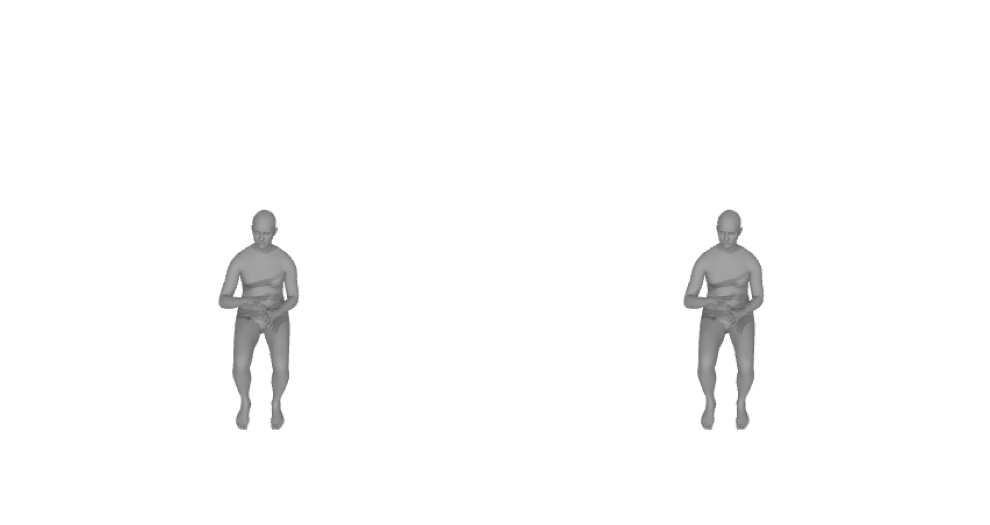

In [35]:
images = render_smpl_params(bm, {'pose_body':all_pose_body}).reshape(1,2,1,400,400,3)
img = imagearray2file(images)
show_image(img[0])

In [36]:
## Generate novel body poses

poZ_body_sample.shape torch.Size([1, 32])
pose_body.shape torch.Size([1, 63])


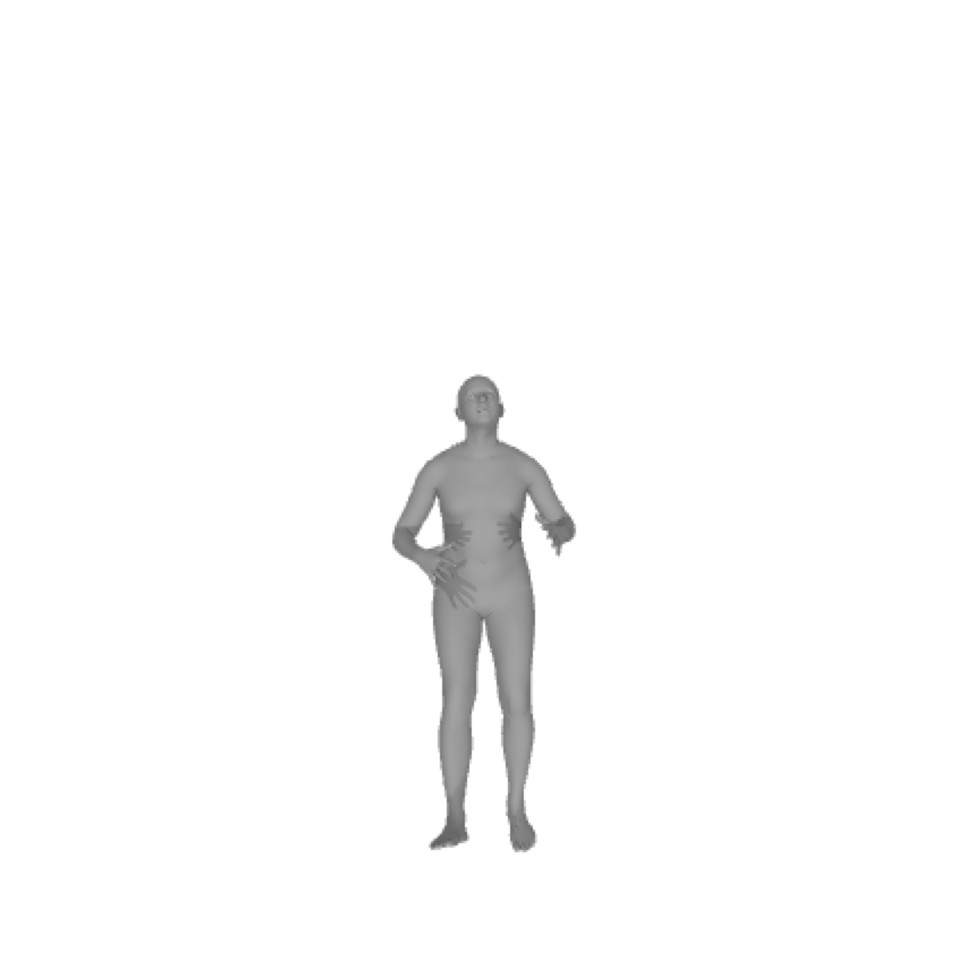

In [47]:
#Sample a 32 dimensional vector from a Normal distribution
poZ_body_sample = torch.from_numpy(np.random.randn(1,32).astype(np.float32)).to('cuda')
pose_body = vp.decode(poZ_body_sample)['pose_body'].contiguous().view(-1, 63)

print('poZ_body_sample.shape', poZ_body_sample.shape)
print('pose_body.shape', pose_body.shape)

images = render_smpl_params(bm, {'pose_body':pose_body}).reshape(1,1,1,400,400,3)
img = imagearray2file(images)
show_image(img[0])

Above we drawn a sample from a 32 dimensional Normal distribution and decoded its value to a full 63 dimensional SMPL body pose vector. The generated image shows the corresponding rendered body. Fo an advanced tutorial on generating poses with VPoser refer to [Link](notebooks/vposer_sampling.ipynb).